# Computer Assignment 3 : Problem 2

## Student names and student numbers:
- Theo Koenig (4922301)
- Tip ten Brink (4927192)
- Lucas van Elderen (4960637)

### General TA feedback:

## Problem 2 : Surface growth

### Exercise 4 : x/16 points

**TA Feedback:**

For 5,000,000 time steps, a Monte Carlo simulation is performed for this problem on a 100x100 grid, with
$k_B T = 0.04$ eV, $\mu = 0.2$ and $J = 0.1$. The following code also includes the potential dislocation.

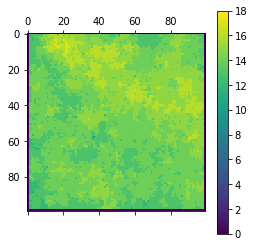

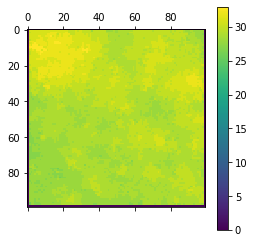

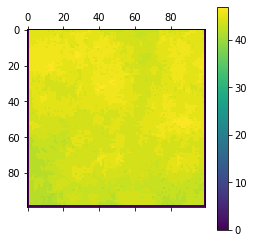

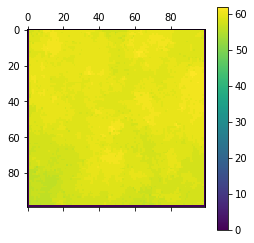

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit

N = 100
kbT = 0.04  # eV
beta = 1 / kbT
mu = 0.2  # eV
J = 0.1  # eV

@jit(nopython=True)
def get_surface_energy(i, j, heights, J, adsorb=True, dislocation=False):
    # Code is somewhat suboptimal to accommodate jit, which makes it much faster
    
    neighbors_h_n = heights[i - 1, j]
    neighbors_h_e = heights[i, j + 1]
    neighbors_h_w = heights[i, j - 1]
    neighbors_h_s = heights[i + 1, j]
    neighbors_h = [neighbors_h_n, neighbors_h_w, neighbors_h_s, neighbors_h_e]

    h_r = heights[i, j]

    if dislocation:
        if (i == N / 2 or i == N / 2 - 1) and j <= N / 2:
            if i == N / 2:
                neighbors_h[0] += 1
            else:
                h_r += 1
                neighbors_h[0] += 1
                neighbors_h[1] += 1
                neighbors_h[3] += 1

    if adsorb:
        h_rl = [h_r + 1, h_r]
    else:
        h_rl = [h_r - 1, h_r]
    sum_a = 0
    sum_na = 0
    for neighbor in neighbors_h:
        sum_a += np.abs(h_rl[0] - neighbor)
        sum_na += np.abs(h_rl[1] - neighbor)
    return [J * sum_a, J * sum_na]


T = 5000000

@jit(nopython=True)
def calculate_heights(T, N, mu, beta, J, dislocation=False):
    R = np.random.random_sample(T)
    a_or_d = np.random.randint(0, 2, T)
    i_R = np.random.randint(1, N - 1, T)
    j_R = np.random.randint(1, N - 1, T)
    
    T = T + 1
    heights = np.zeros((N, N))
    TT = 4
    tt = 0
    heights_t = np.zeros((N, N, TT))
    for t in range(T):
        r = R[t]
        i_r = i_R[t]
        j_r = j_R[t]

        if t % (int(T / 4)) == 0 and t != 0:
            heights_t[:, :, tt] = heights
            tt += 1
        if a_or_d[t]:  # adsorption
            e = get_surface_energy(i_r, j_r, heights, J, adsorb=True, dislocation=dislocation)
            e_ads = e[0]
            e_nads = e[1]
            gibbs = np.exp(beta * (mu - e_ads + e_nads))
            if gibbs > r:
                heights[i_r, j_r] += 1

        else:  # desorption
            e = get_surface_energy(i_r, j_r, heights, J, adsorb=False, dislocation=dislocation)
            e_des = e[0]
            e_ndes = e[1]
            gibbs = np.exp(beta * (-mu - e_des + e_ndes))
            if gibbs > r:
                heights[i_r, j_r] -= 1
    return heights_t


heights_t = calculate_heights(T, N, mu, beta, J, False)

for tt in range(4):
    height = heights_t[:, :, tt]
    fig = plt.matshow(height)
    plt.colorbar(fig)
    plt.show()

heights = heights_t[:, :, -1]

Above are four plots at 25%, 50%, 75% and 100% of the time steps. They show the heights on the surface. The boundaries
are kept at zero and no adsorption or desorption takes place there.

### Exercise 5 : x/16 points

**TA Feedback:**

Dislocation is now set to True, so in this case there is a dislocation between $i = N / 2$ and $i = N / 2 - 1$
for $j$ up until $N / 2$, with the height having a difference of $1$. The code is run for 1,000,000 time steps.
For much larger time steps, the spiral becomes too smooth to see.

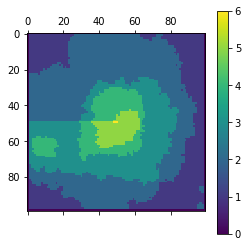

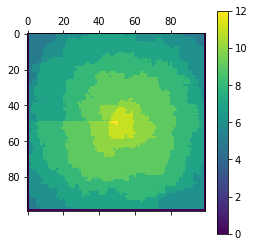

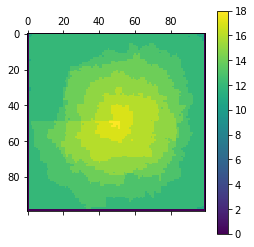

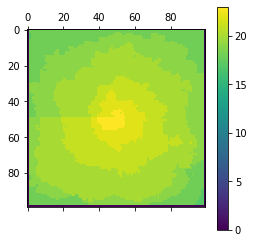

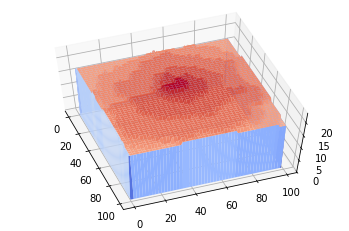

In [16]:
from mpl_toolkits.mplot3d import Axes3D

T = 10000000

kbT = 0.026  # eV
beta = 1 / kbT
mu = 0.16  # eV

heights_t = calculate_heights(T, N, mu, beta, J, True)

for tt in range(4):
    height = heights_t[:, :, tt]
    fig = plt.matshow(height)
    plt.colorbar(fig)
    plt.show()

heights = heights_t[:, :, -1]

def make_fig(heights):
    _x = np.arange(0, heights.shape[0])
    _y = np.arange(0, heights.shape[1])
    X, Y = np.meshgrid(_x, _y)
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(X, Y, heights.T, cmap=plt.get_cmap('coolwarm'),
                           linewidth=0, antialiased=True)
    ax.view_init(elev=60, azim=-20)

    plt.show()


make_fig(heights)

Four heightmap plots are shown for 25%, 50%, 75% and 100% of the time steps. The final image is also
shown in 3D to give a clearer picture of the spiral.

